# 4_inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.decomposition import PCA
#from WMSE import WMSE

import tensorflow as tf
import time
import json
import pandas as pd
import pickle
from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator

from dynesty import NestedSampler
import scipy 
import corner
from dynesty import utils as dyfunc

### inverse PCA layer
#from InversePCA import InversePCA 
### 

### 

### Comment following out if running from laptop:
os.environ["CUDA_VISIBLE_DEVICES"]="1"


physical_devices = tf.config.list_physical_devices("GPU") 
gpu0usage = (tf.config.experimental.get_memory_info("GPU:0")["current"])

print("Current GPU usage:\n"
     + " - GPU0: " + str(gpu0usage) + "B\n")

2024-03-20 10:58:22.666628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 10:58:22.666661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 10:58:22.667660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 10:58:22.672616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 10:58:23.213651: W tensorflow/compiler/tf2

Current GPU usage:
 - GPU0: 0B



2024-03-20 10:58:23.998540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18447 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [18]:
class ns():
    def __init__(self, priors, observed_vals, observed_unc, pitchfork):
        self.priors = priors
        self.obs_val = observed_vals
        self.obs_unc = observed_unc
        self.ndim = len(priors)
        self.pitchfork = pitchfork
    
    def ptform(self, u):

        x = np.array([self.priors[i].ppf(u[i])[0] for i in range(self.ndim)])
        return x
        
    
    def model(self, x):
        
        obs = self.pitchfork.predict(np.array([x]))
        return obs
    
    def logl(self, x): 
        m = self.model(x)
        ll = 0.0
        ll += scipy.stats.norm.logpdf(m, loc = self.obs_val, scale = self.obs_unc)
        return 0.0001*np.sum(ll)
    
    def __call__(self, nlive=1000):
        self.sampler = NestedSampler(self.logl, self.ptform, self.ndim, nlive=nlive,  
                                bound='multi', sample='unif')
        self.sampler.run_nested()
        self.results = self.sampler.results
        samples, weights = self.results.samples, np.exp(self.results.logwt - self.results.logz[-1])
        self.post_samples = dyfunc.resample_equal(samples, weights)
        
        return self.post_samples


In [19]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS


In [20]:
pitchfork = emulator("nu6-40")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [21]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
4391517,1.02,0.019516,0.3,2.1,4.383729,1.06897,1.207593,5856.347195,0.017745,625.169126,...,0.514199,0.515225,0.516046,0.515588,0.516236,0.516316,0.515333,0.513249,0.510654,0.508749


In [22]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values
unc = [.5, 1, 0.005] + [1 for _ in range(5,40)]
#unc = [0.1, 0.2, 0.001] + [0.4 for _ in range(5,40)]

In [23]:
"""
Define priors
"""
mass_prior = scipy.stats.uniform(loc=0.9*model_inps["initial_mass"], scale=1.1*model_inps["initial_mass"]-0.9*model_inps["initial_mass"])

Zinit_prior = scipy.stats.uniform(loc=0.9*model_inps["initial_Zinit"], scale=1.1*model_inps["initial_Zinit"]-0.9*model_inps["initial_Zinit"])

Yinit_prior = scipy.stats.uniform(loc=0.9*model_inps["initial_Yinit"], scale=1.1*model_inps["initial_Yinit"]-0.9*model_inps["initial_Yinit"])

MLT_prior = scipy.stats.uniform(loc=0.9*model_inps["initial_MLT"], scale=1.1*model_inps["initial_MLT"]-0.9*model_inps["initial_MLT"])

age_prior = scipy.stats.uniform(loc=0.9*model_inps["star_age"], scale=1.1*model_inps["star_age"]-0.9*model_inps["star_age"])

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

iter: 4122 | +1000 | bound: 2 | nc: 1 | ncall: 38269 | eff(%): 13.743 | loglstar:   -inf < -0.003 <    inf | logz: -3.751 +/-  0.036 | dlogz:  0.001 >  1.009                                         

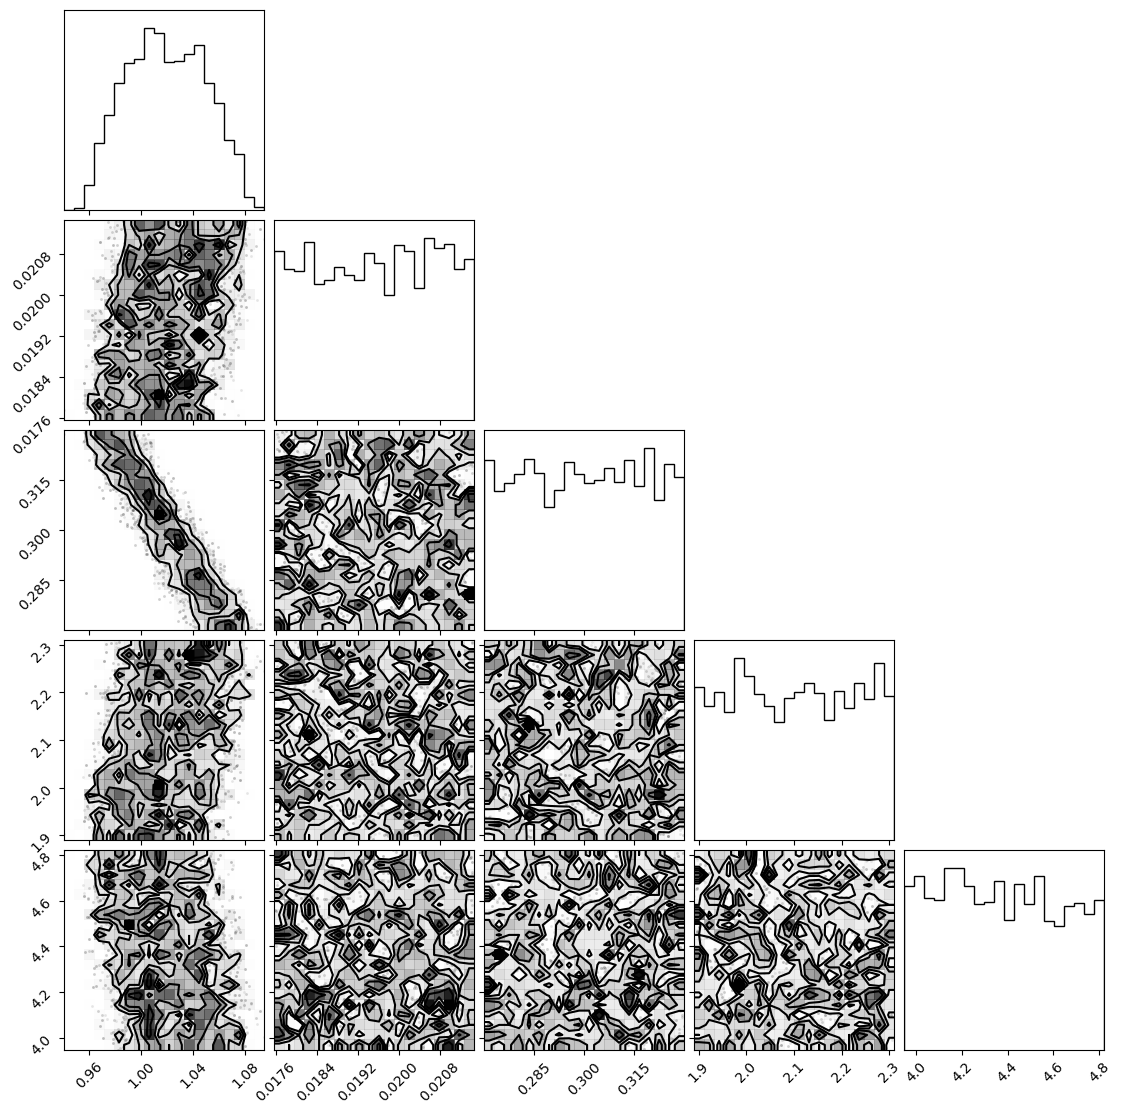

CPU times: user 26min 19s, sys: 4min 49s, total: 31min 8s
Wall time: 23min 10s


In [24]:
%%time
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc,pitchfork=pitchfork)
posterior = sampler()

corner.corner(posterior)
plt.show()

In [13]:
model_inps

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age
4060920,1.0,0.01351,0.24,1.7,4.60741


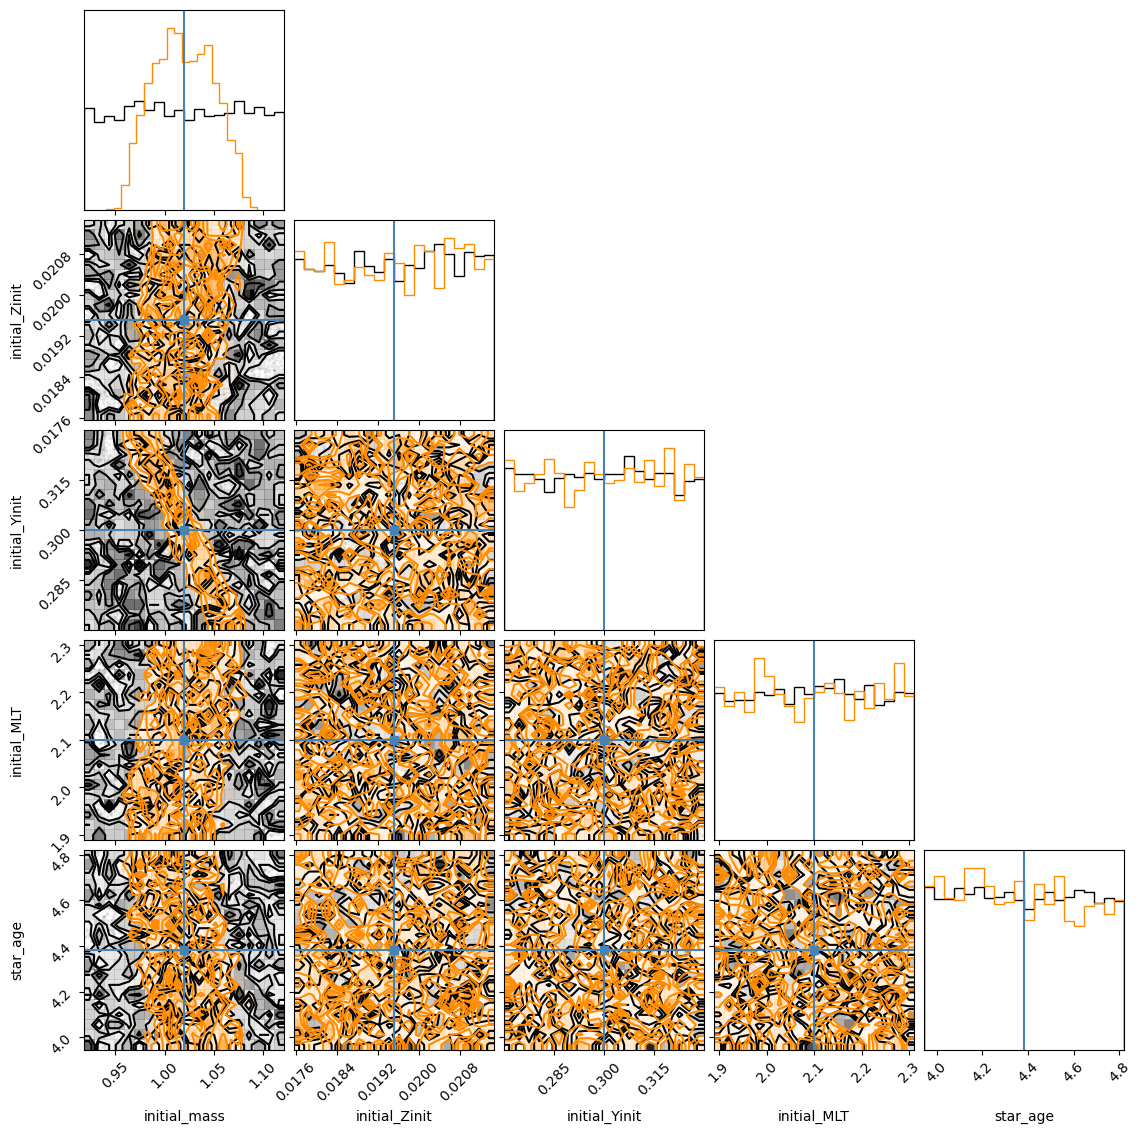

In [32]:
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples);
df_posterior = pd.DataFrame(posterior, columns=inputs)
corner.corner(df_posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='darkorange', fig=figure);
plt.show()

1.02